<a href="https://colab.research.google.com/github/Soobian/deeplearning-project-f1/blob/simple-model/deep_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Imports

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras import mixed_precision
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive

from tensorflow.keras.applications import EfficientNetB0



## Set model parameters

**Parameters**
*   Input size: 224 x 224 px
*   Model class: EfficientNetB0
*   Batch size: 16
*   Epochs: 500





In [18]:
# Set model constants
INPUT_SIZE = (224, 224)
MODEL_CLASS = EfficientNetB0
BATCH_SIZE = 16
EPOCHS = 500


## Set up data

*   Use only in-game data for training and validation


In [19]:
# Connect to Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# Path of datasets
train_dir = '/content/drive/MyDrive/Colab Notebooks/DatasetClassification/f1cars/Game_Dataset/train'
val_dir = '/content/drive/MyDrive/Colab Notebooks/DatasetClassification/f1cars/Game_Dataset/val'


In [21]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomContrast, RandomBrightness
from tensorflow.keras.models import Sequential

# Define the data augmentation pipeline
def create_data_augmentation():
    return Sequential([
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.3),
        RandomZoom(height_factor=0.2, width_factor=0.2),
        RandomTranslation(height_factor=0.1, width_factor=0.1),
        RandomContrast(0.2),
        RandomBrightness(factor=0.2),
    ])


In [22]:
# Get dataset from directory
def get_data_from_dir(dir, batch_size=BATCH_SIZE, input_size=INPUT_SIZE, shuffle=False, augment=False):
    data = keras.utils.image_dataset_from_directory(
        dir,
        labels="inferred",
        label_mode="categorical",
        color_mode="rgb",
        batch_size=batch_size,
        image_size=(input_size[0], input_size[1]),
        shuffle=shuffle
    )

    if augment:
        # Apply data augmentation
        data_augmentation = create_data_augmentation()
        data = data.map(lambda x, y: (data_augmentation(x, training=True), y))

    return data


In [23]:
# Get datasets and create a mixed dataset
def prepare_data(input_size=INPUT_SIZE):
    # Training data
    train_data = get_data_from_dir(train_dir, shuffle=True, augment=True)

    # Validation data
    val_data = get_data_from_dir(val_dir, augment=True)

    # Prefetch to optimize performance
    train_data = train_data.prefetch(tf.data.AUTOTUNE)
    val_data = val_data.prefetch(tf.data.AUTOTUNE)

    return train_data, val_data


In [24]:
# Prepare data with the specified input size and mixing ratio
print(f"Preparing data for EfficientNetB0 with input size {INPUT_SIZE}")
train_data, val_data = prepare_data()


Preparing data for EfficientNetB0 with input size (224, 224)
Found 6288 files belonging to 10 classes.
Found 790 files belonging to 10 classes.


# Model 1: Simple EfficientNetB0 model


## Creating the model

*   Freeze the base model
*   Single dense layer
*   Learning rate: 0.005



In [25]:
LEARNING_RATE = 0.005

In [26]:
def create_model(base_model_class=MODEL_CLASS, input_size=INPUT_SIZE):
    input_layer = Input(shape=(input_size[0], input_size[1], 3), name="input_layer")
    base_model = base_model_class(include_top=False, weights='imagenet')

    # Freeze the base model
    base_model.trainable = False

    # Add base model
    x = base_model(input_layer, training=False)
    x = GlobalAveragePooling2D()(x)

    # Single dense layer
    x = Dense(64, activation='relu')(x)

    # Output layer with 10 classes
    output = Dense(10, activation='softmax', dtype=tf.float32)(x)

    # Create model
    model = keras.Model(inputs=input_layer, outputs=output)

    return model


In [27]:
model = create_model()

print(f"Model created for {MODEL_CLASS} with input size {INPUT_SIZE}.")

# Compile the model using SGD optimizer
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model created for <function EfficientNetB0 at 0x7caed8ba2200> with input size (224, 224).


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          81,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,132,205 (15.76 MB)

 Trainable params: 82,634 (322.79 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Plot the training data

In [28]:
# Plot the training and validation data
def plot_history(history):
  # Extract accuracy and loss from the history object
  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Plot accuracy
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(train_acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.title(f'Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  # Plot loss
  plt.subplot(1, 2, 2)
  plt.plot(train_loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.title(f'Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()


In [29]:
def show_results(history):
  # Plot the training and validation data
  plot_history(history)

  # Get the final training and validation loss and accuracy
  train_loss = history.history['loss'][-1]
  train_accuracy = history.history['accuracy'][-1]
  val_loss = history.history['val_loss'][-1]
  val_accuracy = history.history['val_accuracy'][-1]

  print(f"Training Loss: {train_loss:.4f}")
  print(f"Training Accuracy: {train_accuracy:.4f}")
  print(f"Validation Loss: {val_loss:.4f}")
  print(f"Validation Accuracy: {val_accuracy:.4f}")


## Train model

In [30]:
MODEL_SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/'


In [31]:
# Calculate steps per epoch
def calculate_steps(data, batch_size=BATCH_SIZE):
    return (int)(len(data) / batch_size)

steps_per_epoch = calculate_steps(train_data)
validation_steps = calculate_steps(val_data)


In [32]:
from datetime import datetime

# Save the model with a timestamped filename
def save_model(model, path=MODEL_SAVE_PATH):
  timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
  model_save_path = f"{MODEL_SAVE_PATH}model_{timestamp}.keras"
  model.save(model_save_path)


In [33]:
def train_model(model, train_data, val_data, batch_size=BATCH_SIZE, epochs=EPOCHS):
  # Train the model and capture the training history
  history = model.fit(
    train_data,
    validation_data=val_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
  )

  save_model(model)

  show_results(history)


Epoch 1/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step - accuracy: 0.1285 - loss: 2.3596 - val_accuracy: 0.0000e+00 - val_loss: 2.4429
Epoch 2/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.1184 - loss: 2.3008 - val_accuracy: 0.1667 - val_loss: 2.2877
Epoch 3/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.1518 - loss: 2.2487 - val_accuracy: 0.0417 - val_loss: 2.4751
Epoch 4/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.1610 - loss: 2.2387 - val_accuracy: 0.2083 - val_loss: 2.1648
Epoch 5/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.1587 - loss: 2.2187 - val_accuracy: 0.3125 - val_loss: 2.1577
Epoch 6/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.1901 - loss: 2.1829 - val_accuracy: 0.3958 - val_loss: 2.0694
Epoch 7/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.2575 - loss: 2.1640 - val_accuracy: 0.2292 - val_loss: 2.0864
Epoch 8/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.2752 - loss: 2.1178 - val_accuracy: 0.166

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


24/24 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.4289 - loss: 1.8264 - val_accuracy: 0.3636 - val_loss: 1.8583
Epoch 18/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 528ms/step - accuracy: 0.4559 - loss: 1.8211 - val_accuracy: 0.5417 - val_loss: 1.8291
Epoch 19/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 471ms/step - accuracy: 0.6032 - loss: 1.6954 - val_accuracy: 0.3125 - val_loss: 1.9403
Epoch 20/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 494ms/step - accuracy: 0.5118 - loss: 1.7496 - val_accuracy: 0.0625 - val_loss: 2.2516
Epoch 21/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 476ms/step - accuracy: 0.5247 - loss: 1.7014 - val_accuracy: 0.7500 - val_loss: 1.2753
Epoch 22/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 456ms/step - accuracy: 0.5653 - loss: 1.6375 - val_accuracy: 0.7500 - val_loss: 1.3705
Epoch 23/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 466ms/step - accuracy: 0.5725 - loss: 1.6610 - val_accuracy: 0.7083 - val_loss: 1.3536
Epoch 24/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 468ms/step - accuracy: 0.5506 - loss: 1.5949 - val_accu

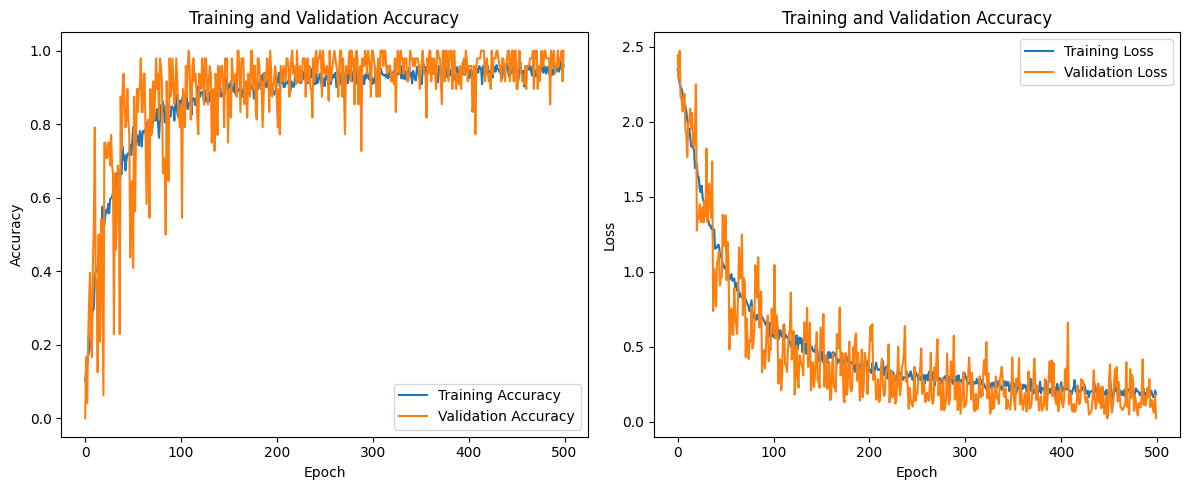

Training Loss: 0.1820
Training Accuracy: 0.9609
Validation Loss: 0.0237
Validation Accuracy: 1.0000


In [34]:
train_model(model, train_data, val_data)


# Model 2: Exponential Decay Learning Rate Schedule


## Creating the model

*   Freeze the base model
*   Single dense layer
*   Learning rate: 0.005 (ExponentialDecay)

In [ ]:
def create_model(base_model_class=MODEL_CLASS, input_size=INPUT_SIZE):
    input_layer = Input(shape=(input_size[0], input_size[1], 3), name="input_layer")
    base_model = base_model_class(include_top=False, weights='imagenet')

    # Freeze the base model
    base_model.trainable = False

    # Add base model
    x = base_model(input_layer, training=False)
    x = GlobalAveragePooling2D()(x)

    # Single dense layer
    x = Dense(64, activation='relu')(x)

    # Output layer with 10 classes
    output = Dense(10, activation='softmax', dtype=tf.float32)(x)

    # Create model
    model = keras.Model(inputs=input_layer, outputs=output)

    return model


In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.005,
    decay_steps=2000,
    decay_rate=0.96
)


In [ ]:
model = create_model()

print(f"Model created for {MODEL_CLASS} with input size {INPUT_SIZE}.")

# Compile the model using SGD optimizer
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model created for <function EfficientNetB0 at 0x7b518b63e7a0> with input size (224, 224).


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          81,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,132,205 (15.76 MB)

 Trainable params: 2,133,338 (8.14 MB)

 Non-trainable params: 1,998,867 (7.63 MB)

## Plot the training data

In [ ]:
# Plot the training and validation data
def plot_history(history):
  # Extract accuracy and loss from the history object
  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Plot accuracy
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(train_acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.title(f'Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  # Plot loss
  plt.subplot(1, 2, 2)
  plt.plot(train_loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.title(f'Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()


In [ ]:
def show_results(history):
  # Plot the training and validation data
  plot_history(history)

  # Get the final training and validation loss and accuracy
  train_loss = history.history['loss'][-1]
  train_accuracy = history.history['accuracy'][-1]
  val_loss = history.history['val_loss'][-1]
  val_accuracy = history.history['val_accuracy'][-1]

  print(f"Training Loss: {train_loss:.4f}")
  print(f"Training Accuracy: {train_accuracy:.4f}")
  print(f"Validation Loss: {val_loss:.4f}")
  print(f"Validation Accuracy: {val_accuracy:.4f}")


## Train model

In [ ]:
MODEL_SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/'


In [ ]:
# Calculate steps per epoch
def calculate_steps(data, batch_size=BATCH_SIZE):
    return (int)(len(data) / batch_size)

steps_per_epoch = calculate_steps(train_data)
validation_steps = calculate_steps(val_data)


In [ ]:
from datetime import datetime

# Save the model with a timestamped filename
def save_model(model, path=MODEL_SAVE_PATH):
  timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
  model_save_path = f"{MODEL_SAVE_PATH}model_{timestamp}.keras"
  model.save(model_save_path)


In [ ]:
def train_model(model, train_data, val_data, batch_size=BATCH_SIZE, epochs=EPOCHS):
  # Train the model and capture the training history
  history = model.fit(
    train_data,
    validation_data=val_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
  )

  save_model(model)

  show_results(history)


Epoch 1/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.0966 - loss: 2.3554 - val_accuracy: 0.1250 - val_loss: 2.3519
Epoch 2/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.1888 - loss: 2.2195 - val_accuracy: 0.1458 - val_loss: 2.2121
Epoch 3/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.2895 - loss: 2.1442 - val_accuracy: 0.2917 - val_loss: 2.0468
Epoch 4/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.3821 - loss: 2.0581 - val_accuracy: 0.3750 - val_loss: 1.9629
Epoch 5/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.4495 - loss: 1.9680 - val_accuracy: 0.4375 - val_loss: 1.9010
Epoch 6/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.5312 - loss: 1.9041 - val_accuracy: 0.6250 - val_loss: 1.5919
Epoch 7/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.6767 - loss: 1.7700 - val_accuracy: 0.7083 - val_loss: 1.5043
Epoch 8/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.6400 - loss: 1.6978 - val_accuracy: 0.7500 - v

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


24/24 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.8989 - loss: 0.8321 - val_accuracy: 0.9545 - val_loss: 0.7915
Epoch 18/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 273ms/step - accuracy: 0.9013 - loss: 0.7920 - val_accuracy: 0.9375 - val_loss: 0.4583
Epoch 19/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.8950 - loss: 0.8127 - val_accuracy: 1.0000 - val_loss: 0.3962
Epoch 20/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.9358 - loss: 0.6348 - val_accuracy: 1.0000 - val_loss: 0.2822
Epoch 21/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - accuracy: 0.9249 - loss: 0.6096 - val_accuracy: 0.9792 - val_loss: 0.3272
Epoch 22/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.9354 - loss: 0.5638 - val_accuracy: 1.0000 - val_loss: 0.2662
Epoch 23/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.9419 - loss: 0.5308 - val_accuracy: 0.9583 - val_loss: 0.2969
Epoch 24/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.9658 - loss: 0.4704 - val_accuracy: 

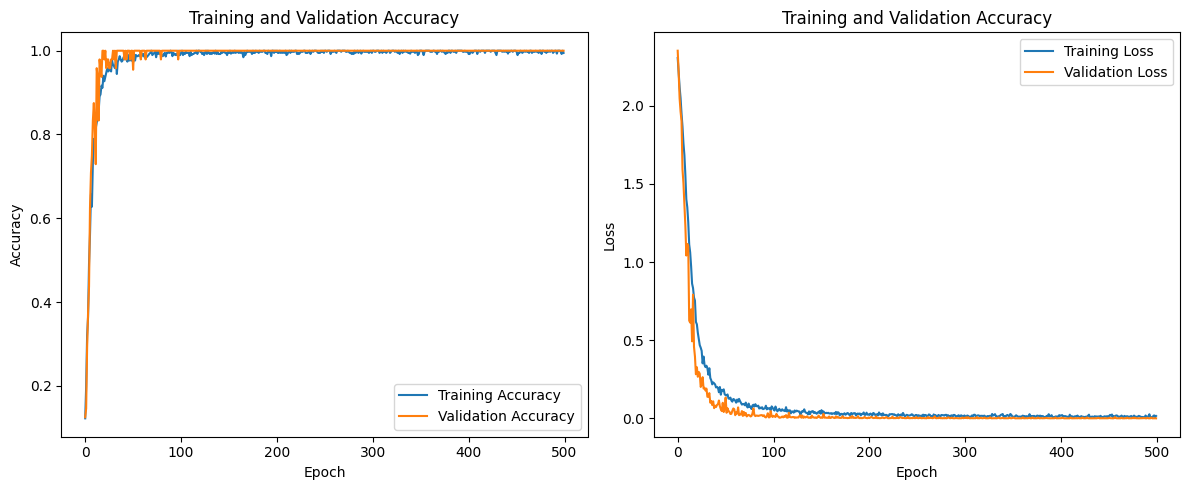

In [ ]:
train_model(model, train_data, val_data)


# Model 3: Exponential Decay Learning Rate Schedule and Unfreeze Layers

## Creating the model

*   Freeze the base model
*   Single dense layer
*   Learning rate: 0.005 (ExponentialDecay)

In [ ]:
def create_model(base_model_class=MODEL_CLASS, input_size=INPUT_SIZE):
    input_layer = Input(shape=(input_size[0], input_size[1], 3), name="input_layer")
    base_model = base_model_class(include_top=False, weights='imagenet')

    # Freeze the base model's first 200 layers
    base_model.trainable = True
    for layer in base_model.layers[:200]:
      layer.trainable = False

    # Add base model
    x = base_model(input_layer, training=False)
    x = GlobalAveragePooling2D()(x)

    # Single dense layer
    x = Dense(64, activation='relu')(x)

    # Output layer with 10 classes
    output = Dense(10, activation='softmax', dtype=tf.float32)(x)

    # Create model
    model = keras.Model(inputs=input_layer, outputs=output)

    return model


In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.005,
    decay_steps=2000,
    decay_rate=0.96
)


In [ ]:
model = create_model()

print(f"Model created for {MODEL_CLASS} with input size {INPUT_SIZE}.")

# Compile the model using SGD optimizer
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


## Plot the training data

In [ ]:
# Plot the training and validation data
def plot_history(history):
  # Extract accuracy and loss from the history object
  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Plot accuracy
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(train_acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.title(f'Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  # Plot loss
  plt.subplot(1, 2, 2)
  plt.plot(train_loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.title(f'Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()


In [ ]:
def show_results(history):
  # Plot the training and validation data
  plot_history(history)

  # Get the final training and validation loss and accuracy
  train_loss = history.history['loss'][-1]
  train_accuracy = history.history['accuracy'][-1]
  val_loss = history.history['val_loss'][-1]
  val_accuracy = history.history['val_accuracy'][-1]

  print(f"Training Loss: {train_loss:.4f}")
  print(f"Training Accuracy: {train_accuracy:.4f}")
  print(f"Validation Loss: {val_loss:.4f}")
  print(f"Validation Accuracy: {val_accuracy:.4f}")


## Train model

In [ ]:
MODEL_SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/'


In [ ]:
# Calculate steps per epoch
def calculate_steps(data, batch_size=BATCH_SIZE):
    return (int)(len(data) / batch_size)

steps_per_epoch = calculate_steps(train_data)
validation_steps = calculate_steps(val_data)


In [ ]:
from datetime import datetime

# Save the model with a timestamped filename
def save_model(model, path=MODEL_SAVE_PATH):
  timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
  model_save_path = f"{MODEL_SAVE_PATH}model_{timestamp}.keras"
  model.save(model_save_path)


In [ ]:
def train_model(model, train_data, val_data, batch_size=BATCH_SIZE, epochs=EPOCHS):
  # Train the model and capture the training history
  history = model.fit(
    train_data,
    validation_data=val_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
  )

  save_model(model)

  show_results(history)


In [ ]:
train_model(model, train_data, val_data)


# Test model

In [35]:
MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/model_1_500epochs_augmented.keras'


In [36]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def test_model(model_path, data):
    # Load the saved model
    model = load_model(model_path)

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(data)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")

    # Make predictions
    predictions = model.predict(data)
    predicted_class_indices = np.argmax(predictions, axis=1)

    # Get true class labels from the test data
    true_class_indices = np.argmax(np.concatenate([y for x, y in data], axis=0), axis=1)

    # Compute the confusion matrix
    cm = confusion_matrix(true_class_indices, predicted_class_indices)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", xticks_rotation='vertical')
    plt.show()

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Round the values to two decimal places
    cm_normalized = np.round(cm_normalized, 2)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
    disp.plot(cmap="Blues", xticks_rotation='vertical')
    plt.show()



### Test with in-game images

In [37]:
test_dir = '/content/drive/MyDrive/Colab Notebooks/DatasetClassification/f1cars/Game_Dataset/test'


In [38]:
test_data = get_data_from_dir(test_dir)
class_names = test_data.class_names

test_data = test_data.prefetch(tf.data.AUTOTUNE)


Found 780 files belonging to 10 classes.


49/49 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.8166 - loss: 0.5212
Test Loss: 0.7689802646636963
Test Accuracy: 0.714102566242218
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 268ms/step


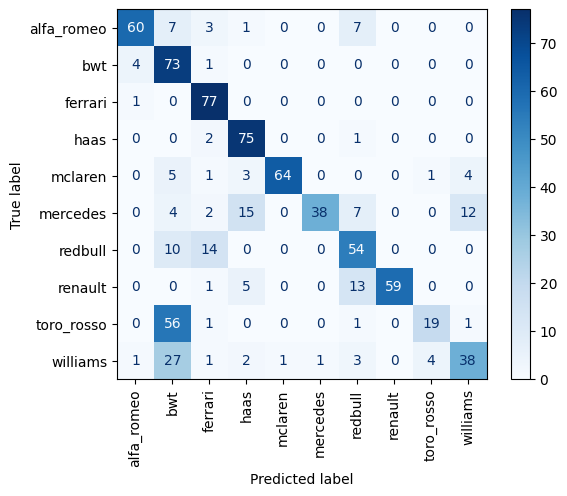

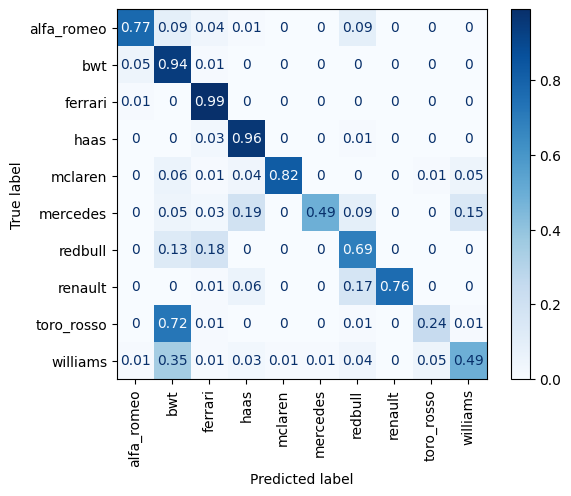

In [39]:
test_model(MODEL_PATH, test_data)


### Test with real-life images

In [40]:
real_life_test_dir = '/content/drive/MyDrive/Colab Notebooks/DatasetClassification/f1cars/test'


In [41]:
real_life_test_data = get_data_from_dir(real_life_test_dir)
class_names = real_life_test_data.class_names

real_life_test_data = real_life_test_data.prefetch(tf.data.AUTOTUNE)


Found 1462 files belonging to 10 classes.


92/92 ━━━━━━━━━━━━━━━━━━━━ 308s 3s/step - accuracy: 0.5982 - loss: 1.4131
Test Loss: 1.618118166923523
Test Accuracy: 0.5779753923416138
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 201ms/step


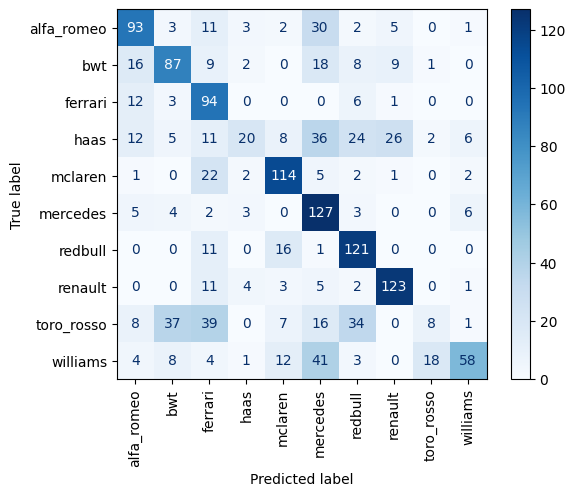

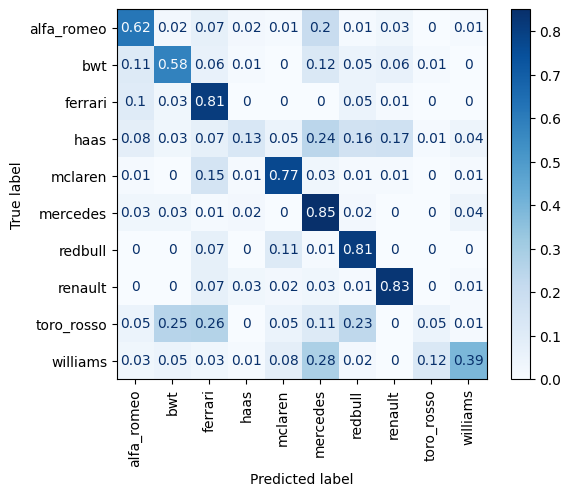

In [42]:
test_model(MODEL_PATH, real_life_test_data)


### Test with real-life images from Autosport

In [43]:
real_life_test_dir = '/content/drive/MyDrive/Colab Notebooks/DatasetClassification/Autosport_Dataset'


In [44]:
real_life_test_data = get_data_from_dir(real_life_test_dir)
class_names = real_life_test_data.class_names

real_life_test_data = real_life_test_data.prefetch(tf.data.AUTOTUNE)


Found 606 files belonging to 10 classes.


38/38 ━━━━━━━━━━━━━━━━━━━━ 181s 5s/step - accuracy: 0.6488 - loss: 1.0275
Test Loss: 1.2525593042373657
Test Accuracy: 0.6072607040405273
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 622ms/step


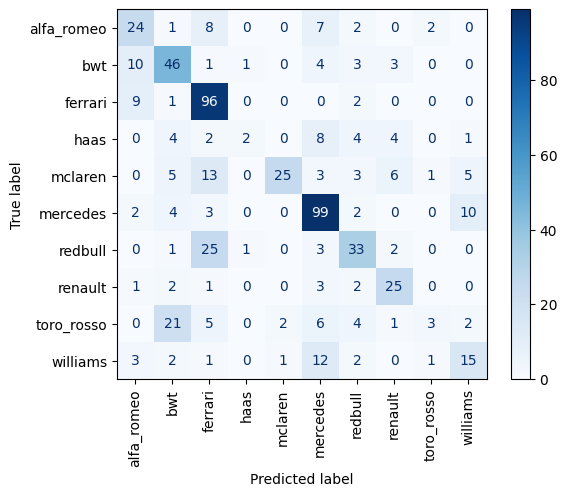

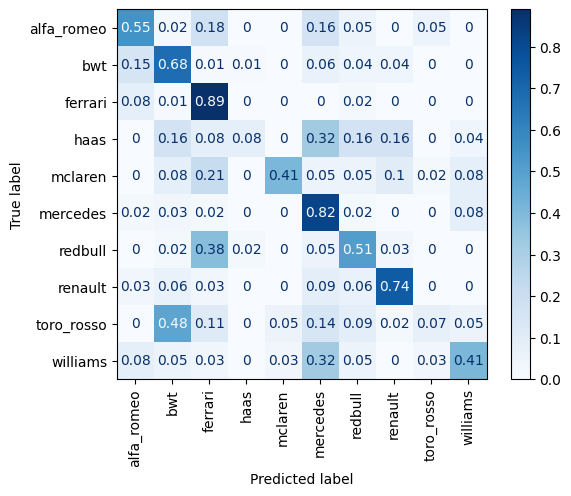

In [45]:
test_model(MODEL_PATH, real_life_test_data)
